In [2]:
pwd

'/home/khanhnt/Desktop/Hit_to_lead/Classification'

In [15]:
# import pandas as pd
# from rdkit import Chem
# from rdkit.Chem import MolStandardize
# from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
# from rdkit.Chem.rdchem import MolSanitizeException

# # Load input CSV
# input_csv_path = "/home/khanhnt/Desktop/Hit_to_lead/Classification/smiles_dataset.csv"  # Adjust path if needed
# df = pd.read_csv(input_csv_path)

# # Helper: Validate SMILES
# def validate_molecule(smiles):
#     try:
#         mol = Chem.MolFromSmiles(smiles)
#         if mol is None:
#             return None
#         Chem.SanitizeMol(mol)
#         return mol
#     except MolSanitizeException:
#         return None

# # Helper: Generate stereoisomers
# def generate_stereoisomers(smiles, mol_id):
#     mol = validate_molecule(smiles)
#     if not mol:
#         return []
#     try:
#         stereo_mols = list(EnumerateStereoisomers(mol))
#     except Exception:
#         return []
#     if len(stereo_mols) > 10:
#         return []
#     return [(Chem.MolToSmiles(iso, isomericSmiles=True), f"{mol_id}_iso{i+1}") for i, iso in enumerate(stereo_mols)]

# # Helper: Generate tautomers
# def generate_tautomers(smiles, mol_id):
#     mol = validate_molecule(smiles)
#     if not mol:
#         return []
#     enumerator = MolStandardize.rdMolStandardize.TautomerEnumerator()
#     try:
#         tautomers = enumerator.Enumerate(mol)
#     except Exception:
#         return []
#     if len(tautomers) > 10:
#         return []
#     return [(Chem.MolToSmiles(tau, canonical=True), f"{mol_id}_tau{i+1}") for i, tau in enumerate(tautomers)]

# # Main process
# final_results = []

# for idx, row in df.iterrows():
#     smiles = row['smile']
#     compound_id = f"compound{row['ID']}"
#     label = row['class']
    
#     if not validate_molecule(smiles):
#         print(f"Invalid SMILES skipped: {compound_id}")
#         continue
    
#     stereoisomers = generate_stereoisomers(smiles, compound_id)
    
#     for stereo_smi, stereo_id in stereoisomers:
#         tautomers = generate_tautomers(stereo_smi, stereo_id)
#         if tautomers:
#             for taut_smi, taut_id in tautomers:
#                 final_results.append((taut_smi, taut_id, label))
#         else:
#             final_results.append((stereo_smi, stereo_id, label))

# # Save results
# output_df = pd.DataFrame(final_results, columns=["smile", "compound_id", "class"])
# output_csv_path = "augmented_smiles_dataset.csv"
# output_df.to_csv(output_csv_path, index=False)

# print(f"Saved augmented dataset to {output_csv_path}")


Saved augmented dataset to augmented_smiles_dataset.csv


In [3]:
# Chemprop Stratified K-Fold Classification with Ensemble Voting

# Imports & Settings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from lightning import pytorch as pl
from chemprop import data, featurizers, models, nn

In [4]:
data_path     = Path("/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/augmented_smiles_dataset.csv")            # or your URL
smiles_column = "smile"
target_column = "class"
n_splits      = 5
seed          = 42
num_workers   = 0
max_epochs    = 100
use_gpu       = False
checkpoint_dir = Path("/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

# Read raw CSV
df = pd.read_csv(data_path)
smis = df[smiles_column].values
ys   = df[[target_column]].values  # shape (N,1)

# Build Chemprop datapoints and raw labels
datapoints = [
    data.MoleculeDatapoint.from_smi(smi, y)
    for smi, y in zip(smis, ys)
]
labels = ys.flatten().astype(int)

In [5]:
# Create Stratified Splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
splits = list(skf.split(datapoints, labels))


In [6]:

#  Featurizer, DataLoaders & Model builder
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

def build_loaders(train_idx, val_idx):
    train_dp = [datapoints[i] for i in train_idx]
    val_dp   = [datapoints[i] for i in val_idx]
    train_ds = data.MoleculeDataset(train_dp, featurizer)
    val_ds   = data.MoleculeDataset(val_dp,   featurizer)
    train_loader = data.build_dataloader(train_ds, num_workers=num_workers)
    val_loader   = data.build_dataloader(val_ds,   num_workers=num_workers, shuffle=False)
    return train_loader, val_loader

def build_model():
    mp   = nn.BondMessagePassing()
    agg  = nn.MeanAggregation()
    ffn  = nn.BinaryClassificationFFN(n_tasks=1)
    # Simply pass the 3 core components; let Chemprop use its defaults for dropout/metrics/etc.
    return models.MPNN(mp, agg, ffn)


In [8]:
# %% 
# Cell 5: Train each fold & save checkpoints
ckpt_paths = []
for fold, (train_idx, val_idx) in enumerate(splits, 1):
    print(f"\n▶ Fold {fold}/{n_splits}")
    train_loader, val_loader = build_loaders(train_idx, val_idx)
    
    model = build_model()  

    trainer = pl.Trainer(
        logger=False,
        enable_checkpointing=False,
        enable_progress_bar=True,
        accelerator="gpu" if use_gpu else "cpu",
        devices=1,
        max_epochs=max_epochs
    )
    trainer.fit(model, train_loader, val_loader)

    ckpt = checkpoint_dir / f"fold_{fold}.ckpt"
    trainer.save_checkpoint(str(ckpt))
    print(f"✔ Saved checkpoint: {ckpt}")
    ckpt_paths.append(str(ckpt))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_transform   | Identity                | 0      | train
5 | metrics         | ModuleList              | 0      | train
--------------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.273     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode



▶ Fold 1/5


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_transform   | Identity                | 0      | train
5 | metrics         | ModuleList              | 0      | train
--------------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.273     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval

✔ Saved checkpoint: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_1.ckpt

▶ Fold 2/5


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_transform   | Identity                | 0      | train
5 | metrics         | ModuleList              | 0      | train
--------------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.273     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval

✔ Saved checkpoint: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_2.ckpt

▶ Fold 3/5


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_transform   | Identity                | 0      | train
5 | metrics         | ModuleList              | 0      | train
--------------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.273     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval

✔ Saved checkpoint: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_3.ckpt

▶ Fold 4/5


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_transform   | Identity                | 0      | train
5 | metrics         | ModuleList              | 0      | train
--------------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.273     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval

✔ Saved checkpoint: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_4.ckpt

▶ Fold 5/5


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


✔ Saved checkpoint: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_5.ckpt


In [9]:
# %% Cell 6: Ensemble Voting with Chemprop-style checkpoint loading

import numpy as np
import pandas as pd
import os
import torch
from sklearn.metrics import accuracy_score
from lightning import pytorch as pl
from chemprop import data, featurizers, models

# 1) Prepare inference datapoints (SMILES only)
smis = df["smile"].tolist()
test_datapoints = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]

# 2) Featurize & make DataLoader
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
test_dataset = data.MoleculeDataset(test_datapoints, featurizer)
test_loader = data.build_dataloader(
    test_dataset,
    shuffle=False,
    num_workers=4  # bump this if you can
)

# 3) Loop over your saved ckpts, load & predict
all_preds = []
device = "cuda" if torch.cuda.is_available() else "cpu"

for ckpt in ckpt_paths:
    # Load the exact same architecture + weights
    model: models.MPNN = models.MPNN.load_from_checkpoint(
        ckpt,
        map_location=device
    ).eval()

    trainer = pl.Trainer(
        logger=False,
        enable_progress_bar=False,
        accelerator="gpu" if device == "cuda" else "cpu",
        devices=1
    )

    # .predict returns a list of batches (each a Tensor of shape [batch_size, n_tasks])
    pred_batches = trainer.predict(model, test_loader)

    # flatten and threshold
    probs = np.concatenate([b.cpu().numpy().flatten() for b in pred_batches])
    preds = (probs >= 0.5).astype(int)
    all_preds.append(preds)

# 4) Majority‐vote ensemble
votes       = np.stack(all_preds, axis=1)  # shape (N, n_models)
ensemble_pred = (votes.sum(axis=1) >= (len(all_preds) / 2)).astype(int)

# 5) Accuracy
true_labels = df["class"].values
acc = accuracy_score(true_labels, ensemble_pred)
print(f"🗳️ Ensemble majority‐vote accuracy: {acc:.4f}")

# 6) Build & display result table
df_results = df.rename(columns={"class": "true_class"}).copy()
for i, preds in enumerate(all_preds, start=1):
    df_results[f"model_{i}"] = preds
df_results["ensemble_pred"] = ensemble_pred

from IPython.display import display
display(df_results)

# 7) Save to CSV
out_dir = "/home/khanhnt/Desktop/Hit_to_lead/utils/Classification"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "ensemble_predictions.csv")
df_results.to_csv(csv_path, index=False)
print(f"Saved prediction table to: {csv_path}")


/home/khanhnt/Downloads/yes/envs/DrugEx/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_loc

🗳️ Ensemble majority‐vote accuracy: 0.9709


,smile,compound_id,true_class,model_1,model_2,model_3,model_4,model_5,ensemble_pred
0,Cc1cccc(OC2CCN(C(=O)C3C=CC4=NN=NC4=C3)CC2)c1,compound1_iso1_tau1,0,0,0,0,0,0,0
1,Cc1cccc(OC2CCN(C(=O)c3ccc4[nH]nnc4c3)CC2)c1,compound1_iso1_tau2,0,0,0,0,0,0,0
2,Cc1cccc(OC2CCN(C(=O)c3ccc4n[nH]nc4c3)CC2)c1,compound1_iso1_tau3,0,0,0,0,0,0,0
3,Cc1cccc(OC2CCN(C(=O)c3ccc4nn[nH]c4c3)CC2)c1,compound1_iso1_tau4,0,0,0,0,0,0,0
4,Cc1cccc(OC2CCN(C(O)=c3ccc4c(c3)N=NN=4)CC2)c1,compound1_iso1_tau5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
98,N=C1CC(=O)N(c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)N1,compound18_iso1_tau1,1,1,1,1,1,1,1
99,N=c1cc(O)n(-c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)[...,compound18_iso1_tau2,1,1,1,1,1,1,1
100,NC1=NN(c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)C(=O)C1,compound18_iso1_tau3,1,1,1,1,1,1,1
101,Nc1cc(=O)n(-c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)[...,compound18_iso1_tau4,1,1,1,1,1,1,1


Saved prediction table to: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/ensemble_predictions.csv


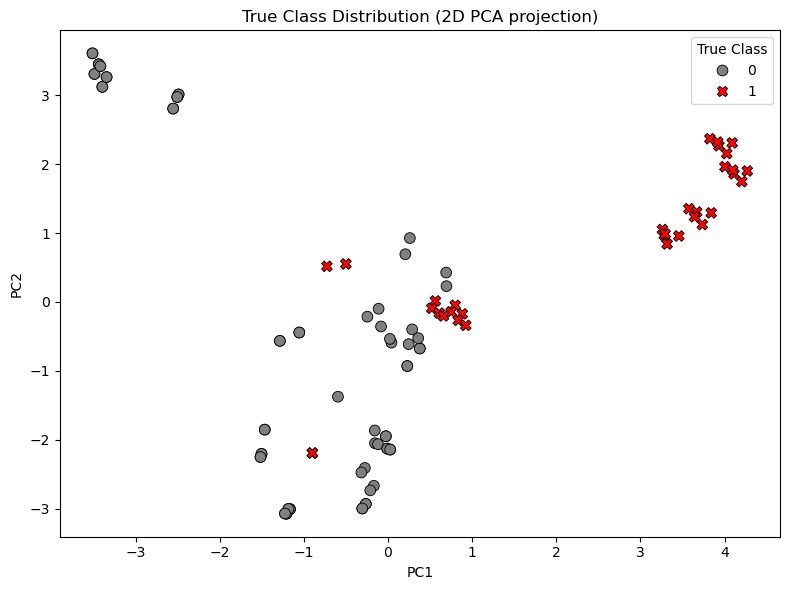

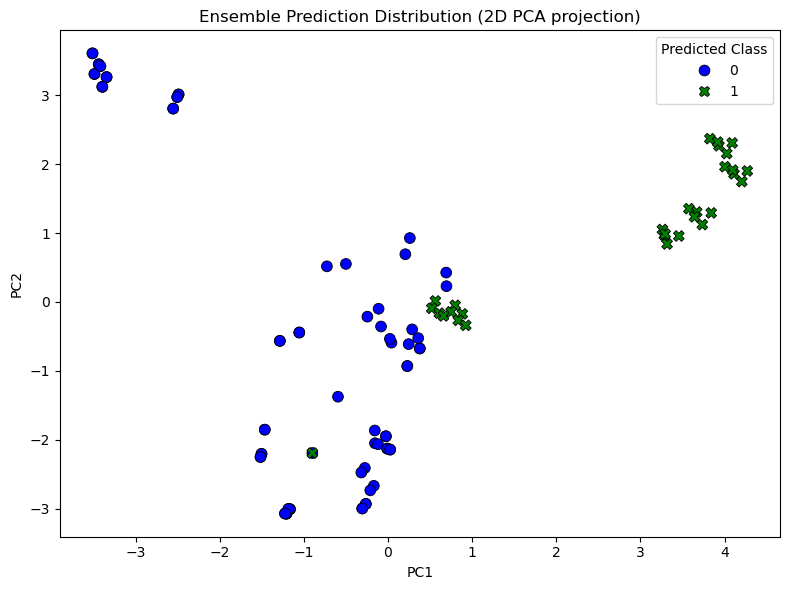

In [10]:
import warnings
warnings.filterwarnings("ignore")

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Suppress RDKit deprecation & parse warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA

# === 1. Load ensemble prediction results ===
csv_path = "/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/ensemble_predictions.csv"
df_results = pd.read_csv(csv_path)

# === 2. Generate Morgan fingerprints ===
def featurize_smiles(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

fingerprints = np.array([featurize_smiles(smi) for smi in df_results["smile"]])

# === 3. PCA for 2D visualization ===
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(fingerprints)

# Add PCA coordinates to dataframe
df_results["PC1"] = reduced_features[:, 0]
df_results["PC2"] = reduced_features[:, 1]

# === 4. Plot True Class Distribution ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_results,
    x="PC1", y="PC2",
    hue="true_class",
    palette={0: "gray", 1: "red"},
    style="true_class",
    s=60,
    edgecolor="black"
)
plt.title("True Class Distribution (2D PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="True Class")
plt.tight_layout()
plt.show()

# === 5. Plot Ensemble Prediction Distribution ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_results,
    x="PC1", y="PC2",
    hue="ensemble_pred",
    palette={0: "blue", 1: "green"},
    style="ensemble_pred",
    s=60,
    edgecolor="black"
)
plt.title("Ensemble Prediction Distribution (2D PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Predicted Class")
plt.tight_layout()
plt.show()



In [ ]:
## Test dataset

In [12]:
import os
import numpy as np
import pandas as pd
import torch
from lightning import pytorch as pl
from chemprop import data, featurizers, models

# ========== USER CONFIG ==========
smi_file_path = "/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/generated_smiles.smi"           # 🔁 Input: 1 SMILES per line
ckpt_dir = "/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints"                 # 📁 Directory of .ckpt files
output_path = "/home/khanhnt/Desktop/Hit_to_lead/utils/Classification/predictions_genered_molecules.csv" # 💾 Output file path
# =================================


# 1) Load SMILES from .smi file
with open(smi_file_path, "r") as f:
    smis = [line.strip().split()[0] for line in f if line.strip()]

# 2) Create MoleculeDatapoints
test_datapoints = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]

# 3) Featurize and build DataLoader
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
test_dataset = data.MoleculeDataset(test_datapoints, featurizer)
test_loader = data.build_dataloader(test_dataset, shuffle=False, num_workers=4)

# 4) Discover .ckpt model files
ckpt_paths = [os.path.join(ckpt_dir, f) for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")]
ckpt_paths.sort()

# 5) Predict using each model
all_preds = []
device = "cuda" if torch.cuda.is_available() else "cpu"

for ckpt in ckpt_paths:
    print(f"🔍 Loading model: {ckpt}")
    model: models.MPNN = models.MPNN.load_from_checkpoint(ckpt, map_location=device).eval()

    trainer = pl.Trainer(
        logger=False,
        enable_progress_bar=False,
        accelerator="gpu" if device == "cuda" else "cpu",
        devices=1
    )

    pred_batches = trainer.predict(model, test_loader)
    probs = np.concatenate([b.cpu().numpy().flatten() for b in pred_batches])
    preds = (probs >= 0.5).astype(int)
    all_preds.append(preds)

# 6) Consensus voting (All must be 1 → 1, else 0)
votes = np.stack(all_preds, axis=1)  # shape (N, n_models)
ensemble_pred = (votes.sum(axis=1) == len(all_preds)).astype(int)

# 7) Create output DataFrame
df_results = pd.DataFrame({"smile": smis})
for i, preds in enumerate(all_preds, start=1):
    df_results[f"model_{i}"] = preds
df_results["ensemble_pred"] = ensemble_pred

# 8) Save to CSV
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_results.to_csv(output_path, index=False)
print(f"✅ Conservative ensemble predictions saved to: {output_path}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔍 Loading model: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_1.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔍 Loading model: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_2.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔍 Loading model: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_3.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔍 Loading model: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_4.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔍 Loading model: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/checkpoints/fold_5.ckpt
✅ Conservative ensemble predictions saved to: /home/khanhnt/Desktop/Hit_to_lead/utils/Classification/predictions_genered_molecules.csv


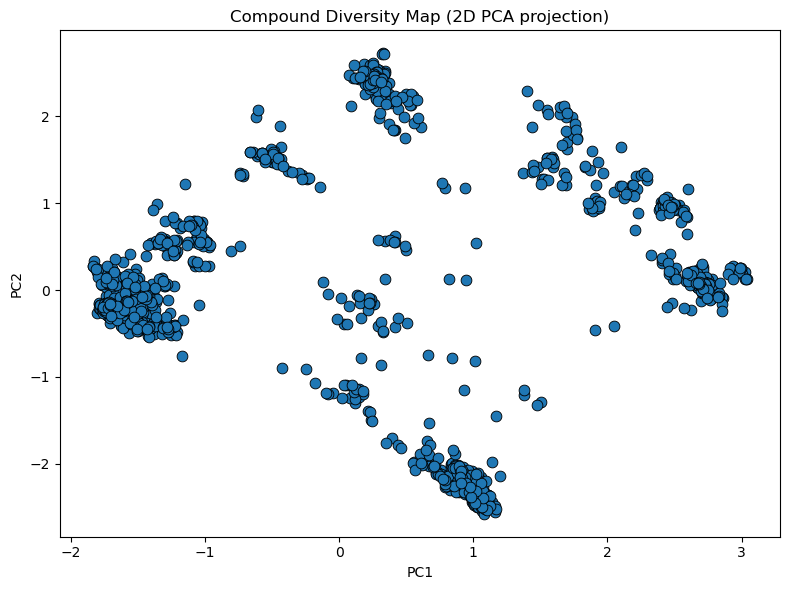

In [2]:
import warnings
warnings.filterwarnings("ignore")

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Suppress RDKit deprecation & parse warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA

# Suppress RDKit and other warnings
warnings.filterwarnings("ignore")

# === 1. Load SMILES from a .smi file ===
smi_path = "/home/khanhnt/Desktop/Hit_to_lead/Classification/generated_smiles.smi"  # 📝 Update this to your actual path

with open(smi_path, 'r') as file:
    smis = [line.strip().split()[0] for line in file if line.strip()]

df = pd.DataFrame({'smile': smis})

# === 2. Generate RDKit Morgan fingerprints ===
def featurize_smiles(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

fingerprints = np.array([featurize_smiles(smi) for smi in df["smile"]])

# === 3. PCA for dimensionality reduction ===
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(fingerprints)

# Add PCA results to DataFrame
df["PC1"] = reduced_features[:, 0]
df["PC2"] = reduced_features[:, 1]

# === 4. Plot: Visualize all compounds in 2D ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    s=60,
    edgecolor="black"
)
plt.title("Compound Diversity Map (2D PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



In [3]:
# Filter SMILES with PC1 > 2 and PC2 > 2
outliers = df[(df["PC1"] > 3) & (df["PC2"] > 0)]

# Print them
print("📌 SMILES with PC1 > 2 and PC2 > 2:")
print(outliers[["smile", "PC1", "PC2"]])

# Optionally, save them to a CSV
outliers.to_csv("high_PC1_PC2_smiles.csv", index=False)


📌 SMILES with PC1 > 2 and PC2 > 2:
                                                  smile       PC1       PC2
9     O=C1CC(Nc2ccccc2)=NN1c1ccc(Oc2ccccc2)c(-c2nn[n...  3.027149  0.209984
146   Cc1ccc(NC2=NN(c3ccc(Oc4ccccc4)c(-c4nn[n-]n4)c3...  3.006528  0.181973
307   O=C(NC1=NN(c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)C(...  3.022630  0.128603
864   O=C(NC1=NN(c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)C(...  3.042490  0.123239
1398  O=C(NC1=NN(c2ccc(Oc3ccccc3)c(-c3nn[n-]n3)c2)C(...  3.034935  0.126929
